In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import MeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
btc_price_history = yf.download('BTC-USD', period='max')
btc_price_history.to_csv('btc_price_history.csv')

[*********************100%%**********************]  1 of 1 completed


In [2]:
btc_df = pd.read_csv('./btc_price_history.csv')
btc_df.columns = btc_df.columns.str.lower()
btc_df['date'] = pd.to_datetime(btc_df['date'])
btc_df.rename(columns={'close': 'btc_close'}, inplace=True)
btc_df = btc_df.drop(['adj close', 'date', 'open', 'high', 'low'], axis=1)
btc_df['returns'] = btc_df['btc_close'].pct_change()
btc_df = btc_df.dropna()
btc_df

,btc_close,volume,returns
1,424.440002,34483200,-0.071926
2,394.795990,37919700,-0.069843
3,408.903992,36863600,0.035735
4,398.821014,26580100,-0.024659
5,402.152008,24127600,0.008352
...,...,...,...
3266,26089.693359,6913768611,0.003123
3267,26106.150391,11002805166,0.000631
3268,27727.392578,29368391712,0.062102
3269,27297.265625,16343655235,-0.015513


In [3]:
# Split into train and test
train_split = int(len(btc_df) * 0.90)
test_split = len(btc_df) - train_split
df_train = btc_df.iloc[0:train_split, :]
df_test = btc_df.iloc[train_split:len(btc_df), :]

In [5]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_train.index, y=df_train['btc_close'], name="BTC Close"), secondary_y=False)
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['volume'], name="Volume", line=dict(color='purple'), opacity=0.4), secondary_y=True)

fig.update_layout(title_text="Bitcoin Close Prices and Volume")
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text="BTC Close Price", secondary_y=False, type="log", dtick=1)
fig.update_yaxes(title_text="Volume", secondary_y=True, type="log", dtick=1)
fig.write_image("price_vs_volume.png")
fig.show()

In [6]:
# Turn into np array
train_data = df_train.loc[:, ["btc_close", "volume", "returns"]].values
test_data = df_test.loc[:, ["btc_close", "volume", "returns"]].values
# float32 if need to save memory.
train_data = train_data.astype("float32")
test_data = test_data.astype("float32")
print(train_data.shape,test_data.shape)

(2943, 3) (327, 3)


In [7]:
scalers = {col: MinMaxScaler(feature_range=(0, 1)) for col in ["btc_close", "volume"]}

for col in ["btc_close", "volume"]:
    train_data[:, df_train.columns.get_loc(col)] = scalers[col].fit_transform(train_data[:, df_train.columns.get_loc(col)].reshape(-1, 1)).ravel()
    test_data[:, df_test.columns.get_loc(col)] = scalers[col].transform(test_data[:, df_test.columns.get_loc(col)].reshape(-1, 1)).ravel()

In [8]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Scaled BTC Close Price", "Scaled Volume", "Returns"))

fig.add_trace(go.Scatter(x=df_train.index, y=train_data[:, df_train.columns.get_loc("btc_close")], name='scaled price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_train.index, y=train_data[:, df_train.columns.get_loc("volume")], name='scaled volume', line=dict(color='red')), row=1, col=2)
fig.add_trace(go.Scatter(x=df_train.index, y=train_data[:, df_train.columns.get_loc("returns")], name='returns', line=dict(color='green')), row=1, col=3)
fig.add_shape(type='line', x0=df_train.index[0], y0=df_train['returns'].mean(), x1=df_train.index[-1], y1=df_train['returns'].mean(),
              line=dict(color='purple', width=2, dash='dash'), row=1, col=3)
fig.update_layout(height=500, width=1000, showlegend=True)
fig.write_image("scaled_stats.png")
fig.show()

In [9]:
# split train data, so it now becomes the train & validation parts. The original untouched 'df_test' split from 'btc_df' will become the test part later.
train_split = int(len(train_data) * 0.50)
val_split = len(train_data) - train_split
train_scaled = train_data[0:train_split, :]
val_scaled = train_data[train_split:len(train_data), :]

print(train_scaled.shape, val_scaled.shape)

(1471, 3) (1472, 3)


In [10]:
def create_sequences(data, time_step):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        slice = data[i:(i + time_step), :]
        dataX.append(slice)
        dataY.append(data[i + time_step, 2]) # '2' because 'returns' is in the 3rd column, which is what we are predicting.
    return np.array(dataX), np.array(dataY)

time_step = 10
trainX, trainY = create_sequences(train_scaled, time_step)
valX, valY = create_sequences(val_scaled, time_step)
testX, testY = create_sequences(test_data, time_step)

print(trainX.shape, trainY.shape, valX.shape, valY.shape, testX.shape, testY.shape)

(1460, 10, 3) (1460,) (1461, 10, 3) (1461,) (316, 10, 3) (316,)


In [12]:
# Build Model
model = Sequential()
model.add(LSTM(256, input_shape = (time_step, 3)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss= "mean_squared_error", optimizer = "adam")
model.fit(trainX, trainY, epochs=50, batch_size=50)

Epoch 1/50
30/30 [==============================] - 2s 12ms/step - loss: 0.0016
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 11/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0016
Epoch 12/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 13/50
30/30 [==================

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               266240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 266497 (1.02 MB)
Trainable params: 266497 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# predict with model
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# calculate RMSE, pearson correlation, RMSPE, Directional Accuracy
train_score = np.sqrt(mean_squared_error(trainY, trainPredict))
val_score = np.sqrt(mean_squared_error(valY, valPredict))
test_score = np.sqrt(mean_squared_error(testY, testPredict))

corr, _ = pearsonr(testY.flatten(), testPredict[:,0])

actual_diff = np.diff(testY.flatten())
predicted_diff = np.diff(testPredict.flatten())

# Calculate if predicted and actual changes have the same sign (indicating correct direction)
directional_accuracy = np.sum(np.sign(testY.flatten()) == np.sign(testPredict.flatten())) / len(testY)

print(f"Train RMSE Score: {train_score:.4f}")
print(f"Val RMSE Score: {val_score:.4f}")
print(f"Test RMSE Score: {test_score:.4f}")
print(f"Test Pearsons correlation: {corr * 100:.2f}%")
print(f"Test Directional accuracy: {directional_accuracy * 100:.2f}%")

10/10 [==============================] - 0s 6ms/step
Train RMSE Score: 0.0392
Val RMSE Score: 0.0387
Test RMSE Score: 0.0253
Test Pearsons correlation: 11.06%
Test Directional accuracy: 53.16%


In [15]:
# Get differences between predictions and actual values
train_diff = np.abs(trainY.flatten() - trainPredict.flatten())
val_diff = np.abs(valY.flatten() - valPredict.flatten())
test_diff = np.abs(testY.flatten() - testPredict.flatten())

trainPredictPlot = np.empty_like(train_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(trainPredict) + time_step, :] = trainPredict

valPredictPlot_new = np.empty((len(train_data), 1))
valPredictPlot_new[:, :] = np.nan
valPredictPlot_new[train_split + time_step:len(train_data)-1, :] = valPredict

testPredictPlot = np.empty_like(test_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[time_step:len(testPredict) + time_step, :] = testPredict

In [16]:
def calculate_stats(data_diff):
    stats_dict = {'std': data_diff.std(), 'min': data_diff.min(), 'max': data_diff.max(), 'mean': data_diff.mean()}
    df = pd.DataFrame(stats_dict, index=[0])
    return df

dataframes_dict = {}
datasets = ['train', 'val', 'test']

for dataset in datasets:
    dataset_diff = globals()[f"{dataset}_diff"]  
    dataframes_dict[dataset] = calculate_stats(dataset_diff)

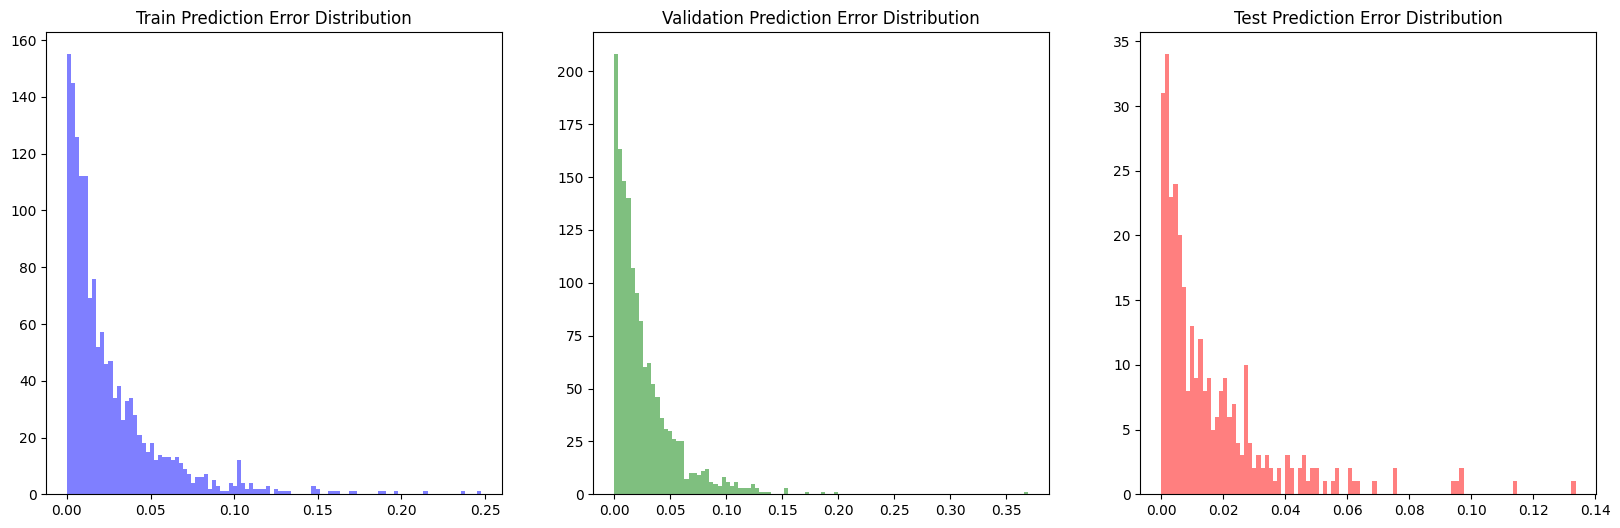

In [17]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.hist(train_diff, bins=100, color='blue', alpha=0.5)
plt.title('Train Prediction Error Distribution')

plt.subplot(1, 3, 2)
plt.hist(val_diff, bins=100, color='green', alpha=0.5)
plt.title('Validation Prediction Error Distribution')

plt.subplot(1, 3, 3)
plt.hist(test_diff, bins=100, color='red', alpha=0.5)
plt.title('Test Prediction Error Distribution')

plt.savefig('error_dists.png')
plt.show()